In [4]:
from __future__ import annotations
from pathlib import Path
from typing import Dict, Tuple, List
from typing import Iterable, Iterator, Optional, List
import os
import json
import pandas as pd
import numpy as np
from loguru import logger
import datetime as dt

In [5]:
from src.data_handler import CoinDataStore

store = CoinDataStore("AVAX")
df_all = store.load_all()
df_all

,price,size,time,seller,buyer
0,19.521999,213.199997,2025-03-22 10:50:22.930512310,8,658
1,19.521999,1.000000,2025-03-22 10:50:23.731759790,19,658
2,19.525999,11.820000,2025-03-22 10:50:43.490273671,161,1260
3,19.525999,39.150002,2025-03-22 10:50:43.490273671,161,19500
4,19.525000,8.800000,2025-03-22 10:50:43.490273671,161,240
...,...,...,...,...,...
1478242,24.966999,1.210000,2025-07-27 08:44:33.762000000,8,1527
1478243,24.971001,308.359985,2025-07-27 08:44:59.437000000,161,5135
1478244,24.971001,203.639999,2025-07-27 08:44:59.437000000,892,5135
1478245,24.971001,11.940000,2025-07-27 08:45:07.130000000,19,170117


In [6]:
sells = df_all[["seller", "time", "price", "size"]].rename(columns={"seller": "wallet_id"}).copy()
sells["is_ask"] = True

buys = df_all[["buyer", "time", "price", "size"]].rename(columns={"buyer": "wallet_id"}).copy()
buys["is_ask"] = False

df_all = pd.concat([sells, buys], ignore_index=True)
df_all

,wallet_id,time,price,size,is_ask
0,8,2025-03-22 10:50:22.930512310,19.521999,213.199997,True
1,19,2025-03-22 10:50:23.731759790,19.521999,1.000000,True
2,161,2025-03-22 10:50:43.490273671,19.525999,11.820000,True
3,161,2025-03-22 10:50:43.490273671,19.525999,39.150002,True
4,161,2025-03-22 10:50:43.490273671,19.525000,8.800000,True
...,...,...,...,...,...
2956489,1527,2025-07-27 08:44:33.762000000,24.966999,1.210000,False
2956490,5135,2025-07-27 08:44:59.437000000,24.971001,308.359985,False
2956491,5135,2025-07-27 08:44:59.437000000,24.971001,203.639999,False
2956492,170117,2025-07-27 08:45:07.130000000,24.971001,11.940000,False


                      value
n_trades       1,478,247.00
total_volume  81,827,152.00
vwap                  20.90
price_min             14.66
price_max             26.84
price_mean            21.02
price_median          21.02
price_std              2.54
size_min               0.01
size_max          47,512.90
size_mean             55.35
size_median           16.08
size_std             205.38
size_p50              16.08
size_p90             123.62
size_p99             606.07


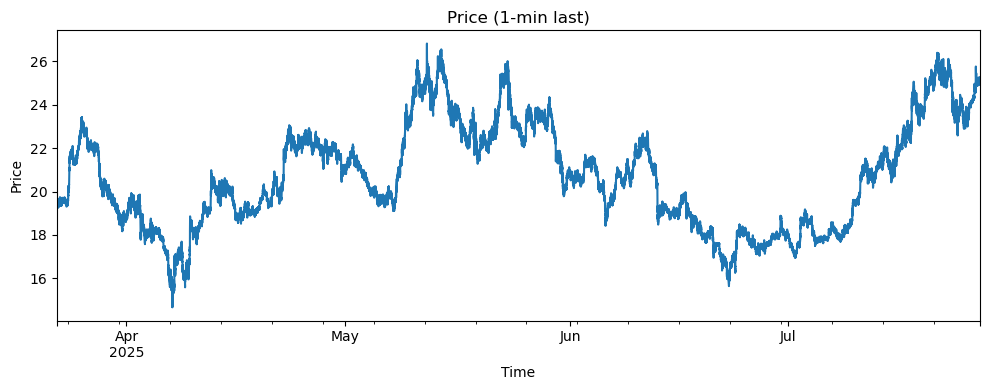

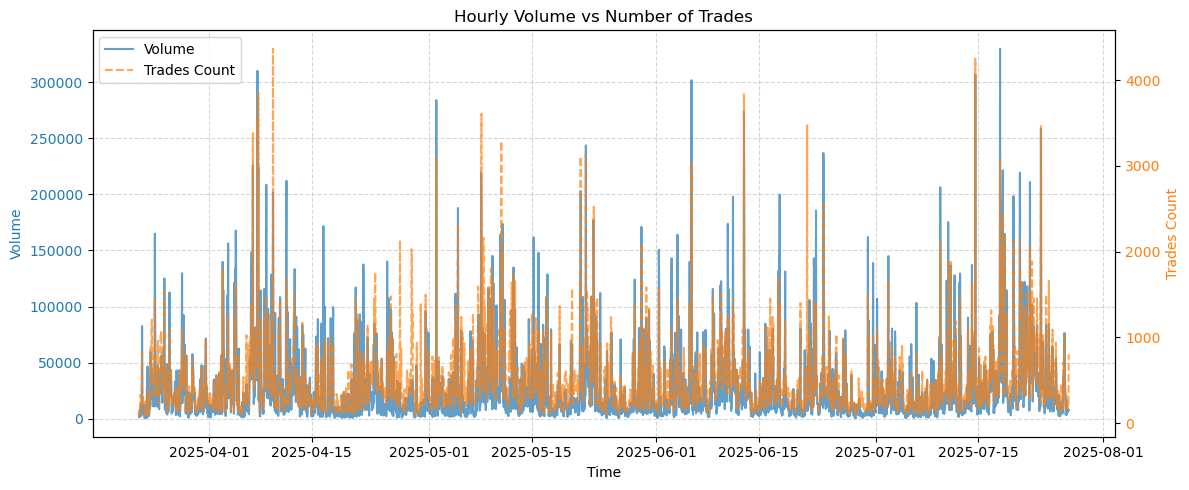

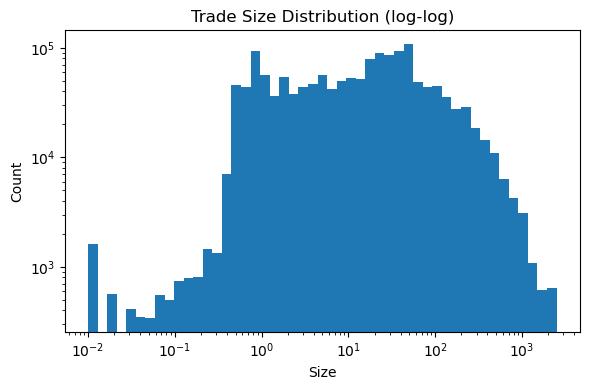

In [7]:
# prerequisites
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TRADE-LEVEL VIEW
trades = df_all[df_all["is_ask"]].copy()
trades = trades.sort_values("time")
trades["notional"] = trades["price"] * trades["size"]

# BASIC STATS
n_trades = len(trades)
tot_vol  = trades["size"].sum()
vwap     = trades["notional"].sum() / max(tot_vol, 1e-12)

price_stats = trades["price"].agg(["min","max","mean","median","std"])
size_stats  = trades["size"].agg(["min","max","mean","median","std"])
size_pct    = trades["size"].quantile([0.5, 0.9, 0.99]).rename({0.5:"p50",0.9:"p90",0.99:"p99"})

summary = {
    "n_trades": n_trades,
    "total_volume": tot_vol,
    "vwap": vwap,
    "price_min": price_stats["min"],
    "price_max": price_stats["max"],
    "price_mean": price_stats["mean"],
    "price_median": price_stats["median"],
    "price_std": price_stats["std"],
    "size_min": size_stats["min"],
    "size_max": size_stats["max"],
    "size_mean": size_stats["mean"],
    "size_median": size_stats["median"],
    "size_std": size_stats["std"],
    "size_p50": size_pct["p50"],
    "size_p90": size_pct["p90"],
    "size_p99": size_pct["p99"],
}

summary_df = pd.Series(summary).to_frame("value")
summary_df["value"] = summary_df["value"].apply(lambda x: f"{x:,.2f}")
print(summary_df)


# TIME BUCKETS (1m + 1h)
trades_min = (
    trades.set_index("time")
          .groupby(pd.Grouper(freq="1min"))
          .agg(
              last_price=("price","last"),
              volume=("size","sum"),
              notional=("notional","sum")
          )
)
trades_min["vwap"] = trades_min["notional"] / trades_min["volume"].where(trades_min["volume"]>0, np.nan)
trades_min["last_price"] = trades_min["last_price"].ffill()  # keep price series continuous

trades_hr = (
    trades.set_index("time")
          .groupby(pd.Grouper(freq="1h"))
          .agg(
              last_price=("price","last"),
              volume=("size","sum"),
              notional=("notional","sum")
          )
)
trades_hr["vwap"] = trades_hr["notional"] / trades_hr["volume"].where(trades_hr["volume"]>0, np.nan)
trades_hr["last_price"] = trades_hr["last_price"].ffill()


# PLOTS
# 1) Price (1-min last) over time
plt.figure(figsize=(10,4))
trades_min["last_price"].plot()
plt.title("Price (1-min last)")
plt.xlabel("Time"); plt.ylabel("Price")
plt.tight_layout(); plt.show()

# 2) Volume per hour
trades_hr = (
    trades.set_index("time")
          .groupby(pd.Grouper(freq="1h"))
          .agg(
              last_price=("price","last"),
              volume=("size","sum"),
              notional=("notional","sum"),
              n_trades=("size","count")   # <-- count of trades
          )
)
trades_hr["vwap"] = trades_hr["notional"] / trades_hr["volume"].where(trades_hr["volume"]>0, np.nan)
trades_hr["last_price"] = trades_hr["last_price"].ffill()


fig, ax1 = plt.subplots(figsize=(12,5))

# Volume line
ax1.plot(trades_hr.index, trades_hr["volume"], color="tab:blue", label="Volume", linewidth=1.5, alpha=0.7)
ax1.set_xlabel("Time")
ax1.set_ylabel("Volume", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True, linestyle="--", alpha=0.5)

# Trade count line (secondary axis)
ax2 = ax1.twinx()
ax2.plot(trades_hr.index, trades_hr["n_trades"], color="tab:orange", label="Trades Count", linewidth=1.5, alpha=0.7, linestyle="--")
ax2.set_ylabel("Trades Count", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("Hourly Volume vs Number of Trades")
plt.tight_layout()
plt.show()


# 3) Trade size distribution (log-log histogram)
plt.figure(figsize=(6,4))
# log scale to avoid memory spikes
sizes = trades["size"].to_numpy()
sizes = sizes[sizes > 0]
bins = np.logspace(np.log10(sizes.min()), np.log10(np.percentile(sizes, 99.9)), 50)
plt.hist(sizes, bins=bins)
plt.xscale("log"); plt.yscale("log")
plt.title("Trade Size Distribution (log-log)")
plt.xlabel("Size"); plt.ylabel("Count")
plt.tight_layout(); plt.show()


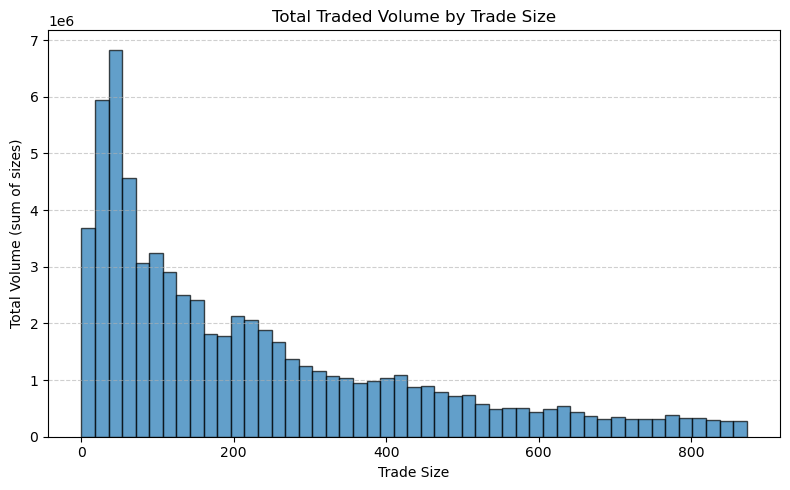

In [8]:
import numpy as np
import matplotlib.pyplot as plt

sizes = trades["size"].to_numpy()
sizes = sizes[sizes > 0]

bins = np.linspace(sizes.min(), np.percentile(sizes, 99.5), 50)
volumes, edges = np.histogram(sizes, bins=bins, weights=sizes)
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# Plot
plt.figure(figsize=(8,5))
plt.bar(bin_centers, volumes, width=np.diff(edges), align="center", alpha=0.7, edgecolor="black")
plt.title("Total Traded Volume by Trade Size")
plt.xlabel("Trade Size")
plt.ylabel("Total Volume (sum of sizes)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



Top 10 wallets by traded volume:
           Trades  Total Volume Sell Share   Trades/Day
wallet_id                                              
161        160441  9,530,737.00      50.0%  1263.314961
22         125489  6,973,105.00      50.0%   988.102362
13372       22526  6,594,980.50      50.0%   204.781818
534         49065  5,635,417.00      49.9%   386.338583
892         87450  5,206,099.50      50.0%   688.582677
480         38377  5,008,946.00      50.0%   302.181102
1621        32490  4,919,995.50      50.0%   264.146341
19         214792  4,486,441.50      49.9%  1691.275591
8          194892  4,276,013.00      50.1%  1534.582677
1844         4239  4,046,746.00      50.0%    33.377953


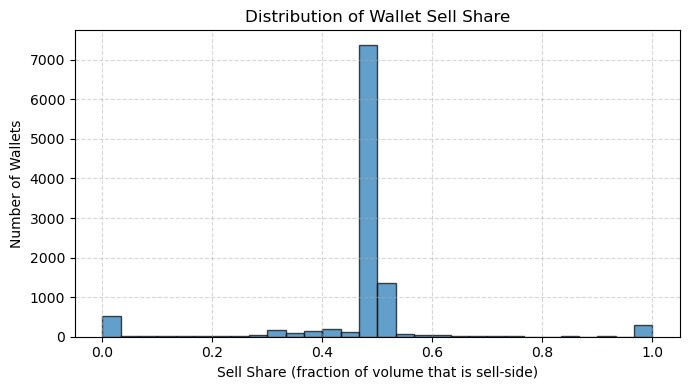

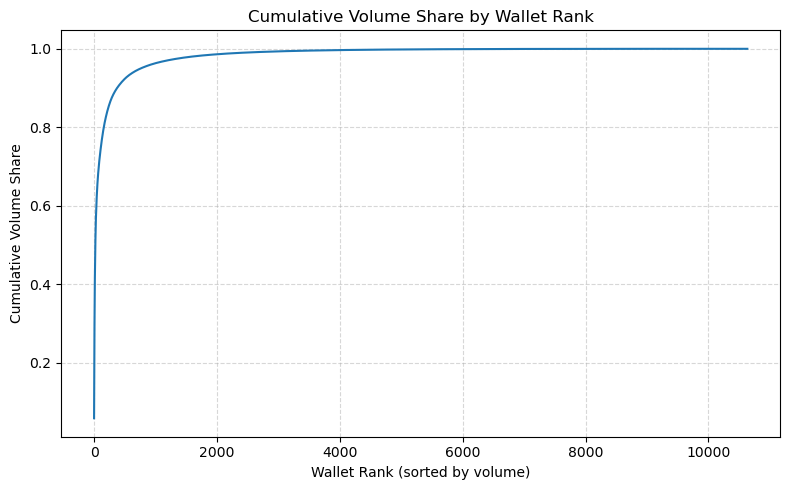

In [9]:
import numpy as np
import pandas as pd

# Ensure types
df_all["time"] = pd.to_datetime(df_all["time"], utc=True)

# Per-wallet aggregates
wallet_stats = (
    df_all
    .groupby("wallet_id")
    .agg(
        n_trades=("size", "count"),
        total_volume=("size", "sum"),
        avg_size=("size", "mean"),
        size_p50=("size", lambda x: np.percentile(x, 50)),
        size_p90=("size", lambda x: np.percentile(x, 90)),
        size_p99=("size", lambda x: np.percentile(x, 99)),
        buy_volume=("size", lambda x: x[~df_all.loc[x.index, "is_ask"]].sum()),
        sell_volume=("size", lambda x: x[df_all.loc[x.index, "is_ask"]].sum()),
        first_trade=("time", "min"),
        last_trade=("time", "max"),
    )
)

wallet_stats["sell_share"] = wallet_stats["sell_volume"] / wallet_stats["total_volume"]
wallet_stats["active_days"] = (wallet_stats["last_trade"] - wallet_stats["first_trade"]).dt.days + 1
wallet_stats["trades_per_day"] = wallet_stats["n_trades"] / wallet_stats["active_days"]

# Concentration
# Share of total volume per wallet
wallet_stats["volume_share"] = wallet_stats["total_volume"] / wallet_stats["total_volume"].sum()

# Top wallets
top_wallets = wallet_stats.sort_values("total_volume", ascending=False).head(10).copy()

# Formatting
top_wallets["total_volume_fmt"] = top_wallets["total_volume"].map(lambda x: f"{x:,.2f}")
top_wallets["sell_share_fmt"] = top_wallets["sell_share"].map(lambda x: f"{x:.1%}")

# Display selected + formatted columns
print("\nTop 10 wallets by traded volume:")
print(
    top_wallets[["n_trades", "total_volume_fmt", "sell_share_fmt", "trades_per_day"]]
    .rename(columns={
        "n_trades": "Trades",
        "total_volume_fmt": "Total Volume",
        "sell_share_fmt": "Sell Share",
        "trades_per_day": "Trades/Day"
    })
)


# Plots
import matplotlib.pyplot as plt

# Histogram of sell share
plt.figure(figsize=(7,4))
wallet_stats["sell_share"].dropna().plot.hist(bins=30, alpha=0.7, edgecolor="black")
plt.title("Distribution of Wallet Sell Share")
plt.xlabel("Sell Share (fraction of volume that is sell-side)")
plt.ylabel("Number of Wallets")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Wallet concentration plot (Pareto-style)
plt.figure(figsize=(8,5))
wallet_stats_sorted = wallet_stats.sort_values("total_volume", ascending=False)
wallet_stats_sorted["cum_volume_share"] = wallet_stats_sorted["total_volume"].cumsum() / wallet_stats_sorted["total_volume"].sum()
wallet_stats_sorted["cum_volume_share"].reset_index(drop=True).plot()
plt.title("Cumulative Volume Share by Wallet Rank")
plt.xlabel("Wallet Rank (sorted by volume)")
plt.ylabel("Cumulative Volume Share")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


/tmp/ipykernel_30630/1503086883.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .groupby(pd.Grouper(freq="1H"))


Annualized realized volatility (hourly): 0.8646
Annualized realized volatility (daily): 0.8471


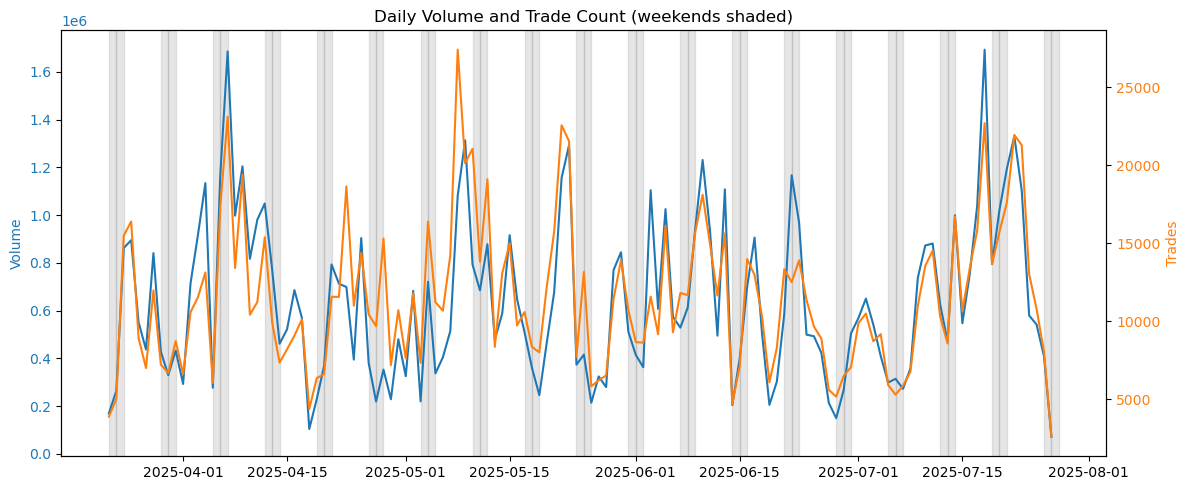

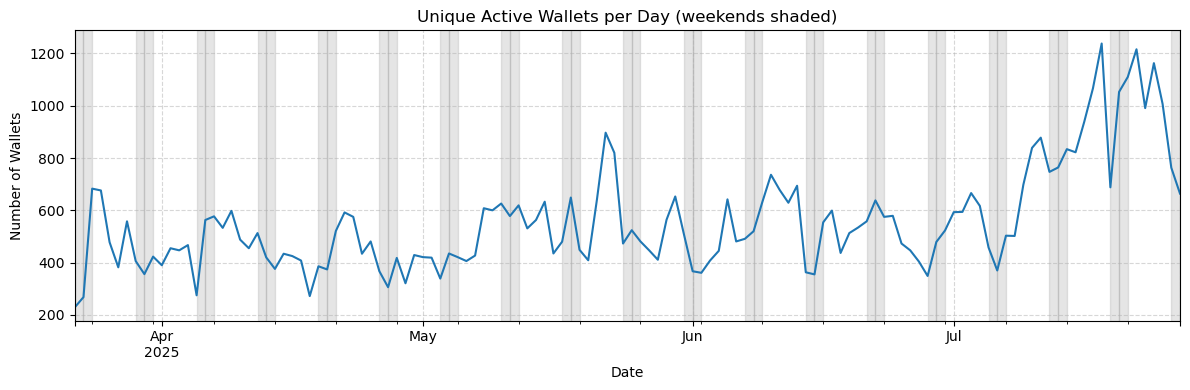

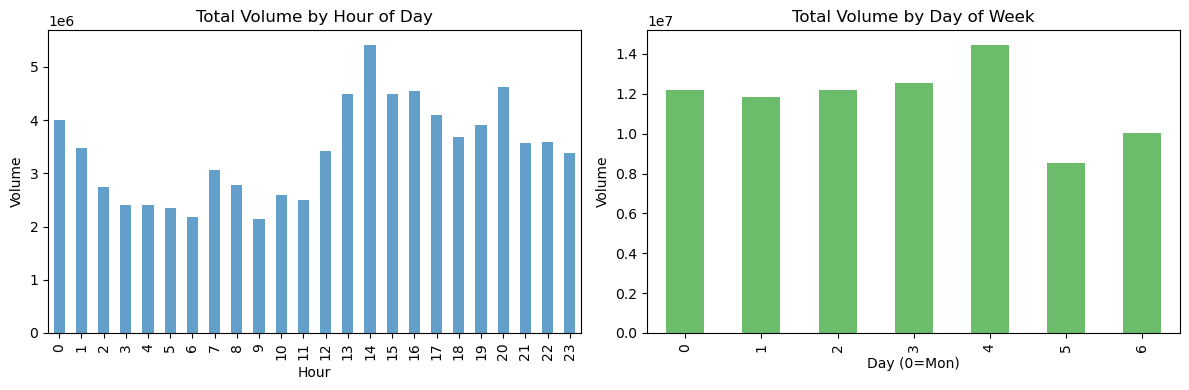

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Deduped trade-level view
trades = df_all[df_all["is_ask"]].copy()
trades["time"] = pd.to_datetime(trades["time"], utc=True)
trades = trades.sort_values("time")
trades["notional"] = trades["price"] * trades["size"]

# Hourly and Daily Aggregates
trades_hr = (
    trades.set_index("time")
          .groupby(pd.Grouper(freq="1H"))
          .agg(
              n_trades=("size","count"),
              volume=("size","sum"),
              notional=("notional","sum"),
              last_price=("price","last")
          )
)
trades_hr["vwap"] = trades_hr["notional"] / trades_hr["volume"].where(trades_hr["volume"]>0, np.nan)
trades_hr["last_price"] = trades_hr["last_price"].ffill()

trades_day = (
    trades.set_index("time")
          .groupby(pd.Grouper(freq="1D"))
          .agg(
              n_trades=("size","count"),
              volume=("size","sum"),
              notional=("notional","sum"),
              last_price=("price","last")
          )
)
trades_day["vwap"] = trades_day["notional"] / trades_day["volume"].where(trades_day["volume"]>0, np.nan)
trades_day["last_price"] = trades_day["last_price"].ffill()

# Volatility
logret_hr = np.log(trades_hr["last_price"]).diff()
vol_hr = logret_hr.std(skipna=True) * np.sqrt(24*365)  # annualized
print(f"Annualized realized volatility (hourly): {vol_hr:.4f}")

logret_day = np.log(trades_day["last_price"]).diff()
vol_day = logret_day.std(skipna=True) * np.sqrt(365)
print(f"Annualized realized volatility (daily): {vol_day:.4f}")

# Active wallets per day
active_wallets_day = (
    df_all.groupby(df_all["time"].dt.floor("1D"))["wallet_id"]
          .nunique()
          .rename("unique_wallets")
)



# Seasonality: hour of day / day of week
trades["hour"] = trades["time"].dt.hour
trades["dow"] = trades["time"].dt.dayofweek  # 0=Monday

hourly_pattern = trades.groupby("hour")["size"].sum()
dow_pattern = trades.groupby("dow")["size"].sum()


# PLOTS

# Daily volume and trades
fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(trades_day.index, trades_day["volume"], color="tab:blue", label="Volume")
ax1.set_ylabel("Volume", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(trades_day.index, trades_day["n_trades"], color="tab:orange", label="Trades")
ax2.set_ylabel("Trades", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

# Highlight weekends
for day in trades_day.index:
    if day.weekday() >= 5:  # Saturday=5, Sunday=6
        ax1.axvspan(day, day + pd.Timedelta(days=1),
                    color="gray", alpha=0.2)

ax1.set_title("Daily Volume and Trade Count (weekends shaded)")
fig.tight_layout()
plt.show()


# Active wallets per day
fig, ax = plt.subplots(figsize=(12,4))

active_wallets_day.plot(ax=ax, color="tab:blue")

# Highlight weekends (shade Sat & Sun)
for day in active_wallets_day.index:
    if day.weekday() >= 5:  # Saturday=5, Sunday=6
        ax.axvspan(day, day + pd.Timedelta(days=1),
                   color="gray", alpha=0.2)

ax.set_title("Unique Active Wallets per Day (weekends shaded)")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Wallets")
ax.grid(True, linestyle="--", alpha=0.5)

fig.tight_layout()
plt.show()



# Seasonality (hour of day / day of week)
fig, axes = plt.subplots(1,2,figsize=(12,4))
hourly_pattern.plot(kind="bar", ax=axes[0], color="tab:blue", alpha=0.7)
axes[0].set_title("Total Volume by Hour of Day")
axes[0].set_xlabel("Hour"); axes[0].set_ylabel("Volume")
dow_pattern.plot(kind="bar", ax=axes[1], color="tab:green", alpha=0.7)
axes[1].set_title("Total Volume by Day of Week")
axes[1].set_xlabel("Day (0=Mon)"); axes[1].set_ylabel("Volume")
plt.tight_layout(); plt.show()
